**Notebook Model Neural Network**

Notebook ini berisi langkah-langkah pembuatan model Neural Network untuk melakukan deteksi dini terhadap karies gigi menggunakan sensor AS7262. Data yang digunakan merupakan intensitas cahaya emisi dari campuran sampel saliva pasien dengan larutan kurkumin yang disinari dengan sumber eksitasi LED UV. 

Data pada penelitian ini terdiri dari enam channel panjang gelombang sensor AS7262 dengan panjang gelombang  450, 500, 550, 570, 600 dan 650 nm serta jenis klasifikasinya (sehat dan karies).

In [80]:
#Import Library yang dibutuhkan
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from keras_sequential_ascii import keras2ascii
from sklearn.preprocessing import LabelEncoder

In [81]:
# membaca file csv dan meload data
df = pd.read_csv(r'D:\Mine\Kuliah\Tugas_Akhir\Program\Fix\5_Tetes\5tetes_normalisasi_oversampled.csv')

In [82]:
# pemisahan data dan labeling data berdasarkan warna panjang gelombang sensor as7262
X = df[['Ungu', 'Biru', 'Hijau', 'Kuning', 'Oranye', 'Merah']].values
y = df['label'].values

In [83]:
# Mengatur urutan kelas sesuai keinginan
label_order = ['sehat', 'karies']
# Mengubah label menjadi nilai numerik
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

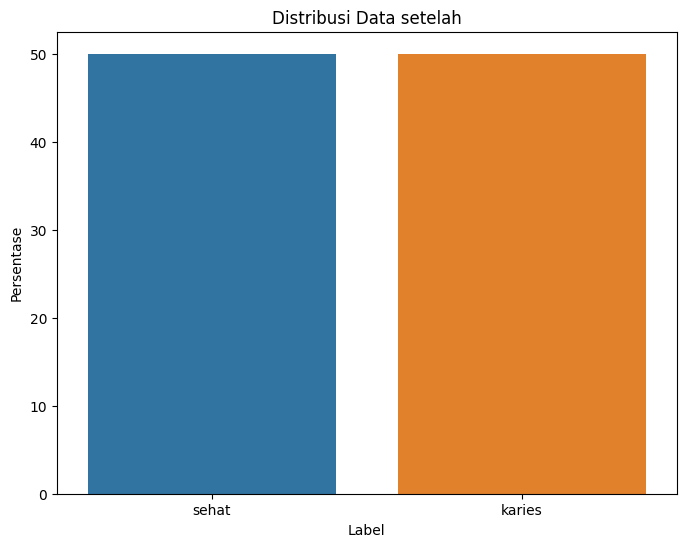

In [84]:
# Menghitung persentase masing-masing label
label_percentages = df['label'].value_counts(normalize=True) * 100

# Menampilkan distribusi data setelah SMOTE menggunakan countplot dengan persentase
plt.figure(figsize=(8, 6))
sns.barplot(x=label_percentages.index, y=label_percentages.values)
plt.xlabel('Label')
plt.ylabel('Persentase')
plt.title('Distribusi Data setelah')
plt.show()


In [85]:
# membagi data menjadi set training dan 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=31, stratify=y)

# Jumlah data pada set pelatihan dan pengujian
print("Jumlah data pada set pelatihan:", len(X_train))
print("Jumlah data pada set pengujian:", len(X_test))

# Proporsi data pada set pelatihan dan pengujian
train_prop = len(X_train) / len(X) * 100
test_prop = len(X_test) / len(X) * 100
print("Proporsi data pada set pelatihan: {:.2f}%".format(train_prop))
print("Proporsi data pada set pengujian: {:.2f}%".format(test_prop))


Jumlah data pada set pelatihan: 39
Jumlah data pada set pengujian: 17
Proporsi data pada set pelatihan: 69.64%
Proporsi data pada set pengujian: 30.36%


In [86]:
# membuat model neural network
def create_model(learning_rate,dropout_rate):
    input_shape = (6,)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu',input_shape=input_shape),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [87]:
# membuat KerasClassifier dengan model yang akan di-grid search
model = KerasClassifier(build_fn=create_model)

# membuat parameter grid
param_grid = {
    'epochs': [1500],
    'batch_size': [8 ,16, 32],
    'learning_rate': [10E-7],
    'dropout_rate': [0.1]
}

# Membuat objek GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train, verbose=0)

# Menampilkan parameter terbaik
print("Best Parameters:", grid_search.best_params_)

# Melatih model dengan parameter terbaik dan menggunakan ModelCheckpoint
best_model = grid_search.best_estimator_
history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test))


C:\Users\Immanuel\AppData\Local\Temp\ipykernel_26528\2084755169.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


1/1 [==============================] - 0s 189ms/step - loss: 1.5466 - accuracy: 0.7143
Best Parameters: {'batch_size': 8, 'dropout_rate': 0.1, 'epochs': 1500, 'learning_rate': 1e-06}
Epoch 1/1500
5/5 [==============================] - 1s 55ms/step - loss: 1.1208 - accuracy: 0.5897 - val_loss: 1.1055 - val_accuracy: 0.7647
Epoch 2/1500
5/5 [==============================] - 0s 14ms/step - loss: 1.0988 - accuracy: 0.5897 - val_loss: 1.0817 - val_accuracy: 0.5294
Epoch 3/1500
5/5 [==============================] - 0s 14ms/step - loss: 1.0693 - accuracy: 0.5641 - val_loss: 1.0596 - val_accuracy: 0.5294
Epoch 4/1500
5/5 [==============================] - 0s 12ms/step - loss: 1.0445 - accuracy: 0.5897 - val_loss: 1.0387 - val_accuracy: 0.5882
Epoch 5/1500
5/5 [==============================] - 0s 13ms/step - loss: 1.0282 - accuracy: 0.6154 - val_loss: 1.0186 - val_accuracy: 0.7059
Epoch 6/1500
5/5 [==============================] - 0s 12ms/step - loss: 1.0053 - accuracy: 0.6923 - val_loss: 0

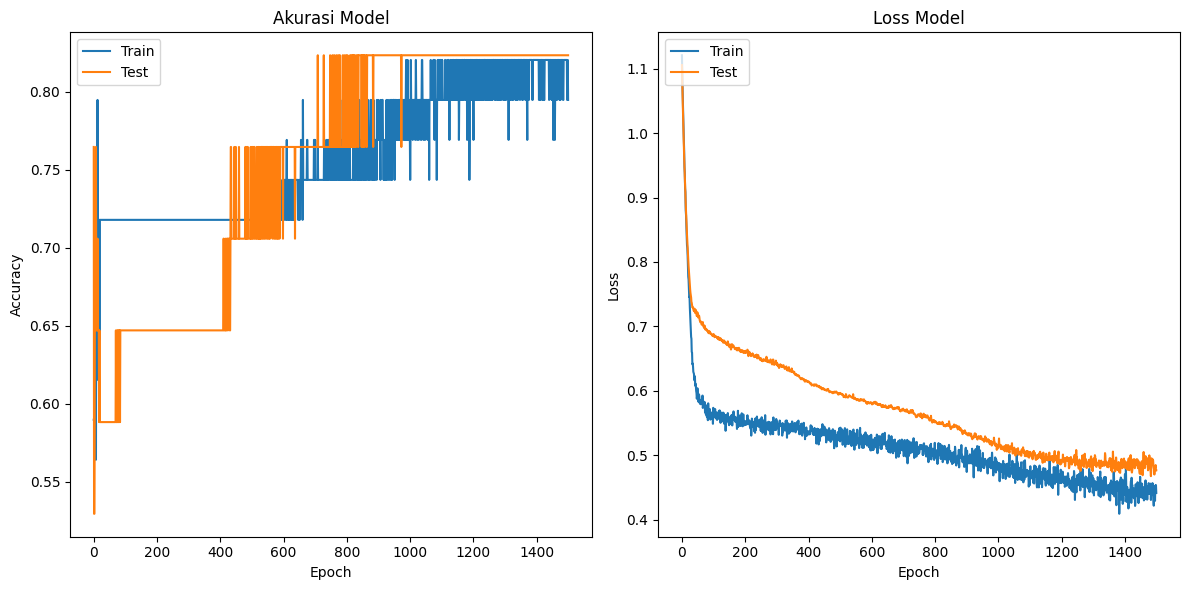

In [88]:
# Menampilkan grafik pelatihan dan kerugian per epoch
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [89]:
# Menyimpan model ke file .h5
best_model.model.save('Model_cv5_oversampled.h5')
print("Model saved as Model_cv5_oversampled")

Model saved as Model_cv5_oversampled


In [90]:
# Memuat model dari file .h5
loaded_model = tf.keras.models.load_model('Model_cv5_oversampled.h5')
keras2ascii(loaded_model)
loaded_model.summary()

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           6
               Dense   XXXXX -------------------       224     6.5%
                relu   #####          32
               Dense   XXXXX -------------------      1056    30.5%
                relu   #####          32
               Dense   XXXXX -------------------      2112    61.1%
                relu   #####          64
             Dropout    | || -------------------         0     0.0%
                       #####          64
               Dense   XXXXX -------------------        65     1.9%
             sigmoid   #####           1
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_276 (Dense)           (None, 32)                224       
                                                                 
 dense_277 (Dense)           (None, 32)              

1/1 [==============================] - 1s 681ms/step


d:\Mine\Kuliah\Tugas_Akhir\Program\venv\lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


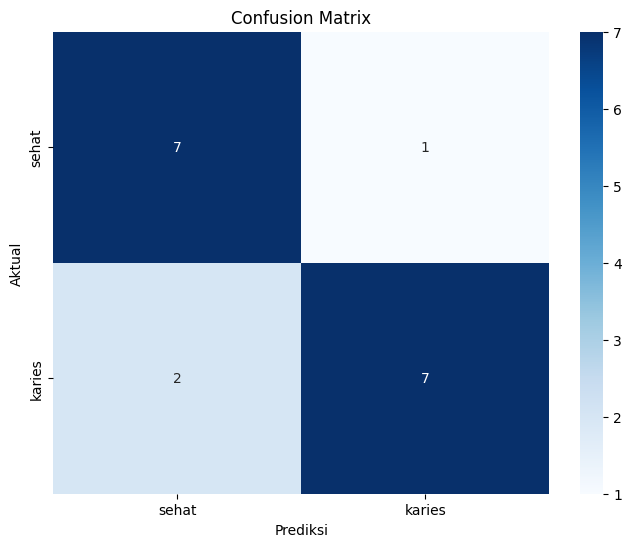

              precision    recall  f1-score   support

      karies       0.88      0.78      0.82         9
       sehat       0.78      0.88      0.82         8

    accuracy                           0.82        17
   macro avg       0.83      0.83      0.82        17
weighted avg       0.83      0.82      0.82        17



In [91]:
# memprediksi kelas
y_pred = best_model.predict(X_test)

# Mengubah prediksi ke dalam bentuk label numerik
y_pred_labels = np.argmax(y_pred, axis=1)

# mengembalikan label ke bentuk semula
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)


# membuat confussion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_order)

# menampilkan confussion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_order, yticklabels=label_order)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

# menampilkan classification report
print(classification_report(y_test_labels, y_pred_labels))

Bagian ini digunakan untuk menguji model dengan data baru yang tidak ada hubungannya dengan proses pelatihan.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Memuat model neural network dari file .h5
model = load_model('Model_cv5_oversampled.h5')

# Menerima input dari pengguna untuk fitur-fitur dipisahkan koma
features = input("Masukkan nilai untuk setiap fitur dipisahkan koma: ")
feature_values = features.split(",")

# Memastikan jumlah fitur yang dimasukkan sesuai dengan yang diharapkan
if len(feature_values) != 6:
    print("Jumlah fitur yang dimasukkan tidak sesuai!")
    exit()

# Mengubah nilai fitur menjadi float dan memasukkannya ke dalam array
input_data = np.array([[float(value) for value in feature_values]])

# Normalisasi data menggunakan MinMaxScaler
scaler = MinMaxScaler()
input_data_scaled = scaler.fit_transform(input_data)

# Memastikan dimensi input yang sesuai dengan model
input_data_scaled = input_data_scaled.reshape(-1, 6)

# Melakukan prediksi menggunakan model
prediction = model.predict(input_data_scaled)

# Menentukan threshold untuk klasifikasi biner
threshold = 0.5

# Menampilkan hasil prediksi
if prediction[0][0] > threshold:
    predicted_class = "Sehat"
else:
    predicted_class = "Karies"

print("Hasil Prediksi:", predicted_class)
